In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Φόρτωση του έτοιμου αρχείου
df = pd.read_csv('household_power_final_preprocessed.csv', index_col=0, parse_dates=True)

print("Δεδομένα φορτώθηκαν:", df.shape)

Δεδομένα φορτώθηκαν: (1435, 63)


In [10]:
# Συνάρτηση που τρέχει όλη τη διαδικασία για έναν συγκεκριμένο στόχο (Target)
def run_regression(target_col, df):
    print(f"\n{'='*40}")
    print(f"  ΕΚΠΑΙΔΕΥΣΗ ΜΟΝΤΕΛΟΥ ΓΙΑ: {target_col}")
    print(f"{'='*40}")

    # --- ΒΗΜΑ 1: Επιλογή Features (Χωρίς Data Leakage) ---
    # Κρατάμε ΜΟΝΟ: Lags, Rolling, και Ημερολογιακά (Is_..., Day_..., Month_...)
    # Πετάμε: Όλες τις μετρήσεις της "τρέχουσας" ημέρας (γιατί αυτές θέλουμε να προβλέψουμε ή δεν τις ξέρουμε ακόμα)

    # Βρίσκουμε όλες τις στήλες που είναι ασφαλείς (έχουν lag, rolling, ή είναι ημερομηνία)
    feature_cols = [c for c in df.columns if
                    ('_lag_' in c) or
                    ('_rolling_' in c) or
                    ('Is_' in c) or
                    ('Day_' in c) or
                    ('Month_' in c)]

    # Αφαιρούμε το target αν κατά λάθος μπήκε στη λίστα (σπάνιο, αλλά για σιγουριά)
    if target_col in feature_cols:
        feature_cols.remove(target_col)

    X = df[feature_cols]
    y = df[target_col]

    print(f"Χρησιμοποιούνται {len(feature_cols)} features.")

    # --- ΒΗΜΑ 2: Διαχωρισμός Train / Test (Χρονικός) ---
    # Κρατάμε το τελευταίο 20% για Test
    train_size = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # --- ΒΗΜΑ 3: Εκπαίδευση (Random Forest) ---
    # Χρησιμοποιούμε Random Forest που είναι πιο δυνατό από απλή γραμμική
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # --- ΒΗΜΑ 4: Αξιολόγηση ---
    # Επειδή τα δεδομένα είναι Scaled, τα σφάλματα είναι σε τυπικές αποκλίσεις
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\nΑποτελέσματα (Scaled Units):")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")  # Αυτό ζητάει η εργασία
    print(f"R²:   {r2:.4f}")

    # --- ΒΗΜΑ 5: Γράφημα ---
    plt.figure(figsize=(15, 5))
    # Δείχνουμε τις πρώτες 100 μέρες του Test set για να φαίνεται καθαρά
    plt.plot(y_test.values[:100], label='Πραγματικό', color='black')
    plt.plot(y_pred[:100], label='Πρόβλεψη', color='orange', linestyle='--')
    plt.title(f'Πρόβλεψη: {target_col} (Next Day)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- ΒΗΜΑ 6: Τα πιο σημαντικά Features ---
    importances = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
    print("\nTop 5 Features που επηρέασαν την πρόβλεψη:")
    print(importances.head(5))


  ΕΚΠΑΙΔΕΥΣΗ ΜΟΝΤΕΛΟΥ ΓΙΑ: Daily_total_power
Χρησιμοποιούνται 47 features.

Αποτελέσματα (Scaled Units):
MAE:  0.4316
RMSE: 0.5869
R²:   0.3842


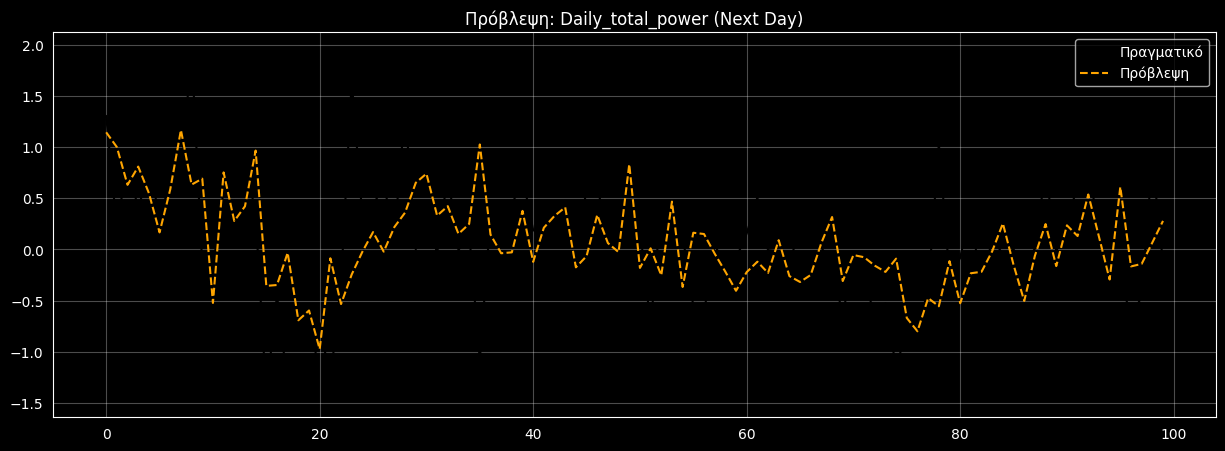


Top 5 Features που επηρέασαν την πρόβλεψη:
Sub_metering_4_lag_1       0.373201
Power_rolling_mean_7       0.102615
Power_rolling_mean_3       0.043182
Global_intensity_lag_7     0.038948
Daily_total_power_lag_1    0.032650
dtype: float64


In [11]:
# ==========================================================
# ΚΛΗΣΕΙΣ ΤΗΣ ΣΥΝΑΡΤΗΣΗΣ
# ==========================================================

# 1. Το βασικό ζητούμενο της εργασίας (Συνολική Κατανάλωση)
run_regression('Daily_total_power', df)

# 2. (Προαιρετικά) Αν θες να δεις και τους υπο-μετρητές ξεχωριστά
# run_regression('Sub_metering_1', df)  # Κουζίνα
# run_regression('Sub_metering_2', df)  # Πλυσταριό
# run_regression('Sub_metering_3', df)  # Θερμοσίφωνας/Κλιματισμός